# Data preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import resample
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from sklearn.tree import plot_tree
import sklearn.metrics as sk
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Embedding
import seaborn as sns
from keras.layers import GaussianNoise
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df1 = pd.read_csv('/content/drive/My Drive/cmput_644_project/datasets/KDDTrain.txt')
df2 = pd.read_csv('//content/drive/My Drive/cmput_644_project/datasets/KDDTest.txt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns_name = (['duration','protocol_type','service','flag',
                 'src_bytes','dst_bytes','land','wrong_fragment',
                 'urgent','hot','num_failed_logins','logged_in',
                 'num_compromised','root_shell','su_attempted',
                 'num_root','num_file_creations','num_shells',
                 'num_access_files','num_outbound_cmds','is_host_login',
                 'is_guest_login','count','srv_count','serror_rate',
                 'srv_serror_rate','rerror_rate','srv_rerror_rate',
                 'same_srv_rate','diff_srv_rate','srv_diff_host_rate',
                 'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                 'dst_host_diff_srv_rate','dst_host_same_src_port_rate',
                 'dst_host_srv_diff_host_rate','dst_host_serror_rate',
                 'dst_host_srv_serror_rate','dst_host_rerror_rate',
                 'dst_host_srv_rerror_rate','attack','level'])

DF1.columns = columns_name
DF2.columns = columns_name

df_NSLKDD = pd.concat([DF1, DF2], axis=0)

df_NSLKDD.drop('level', axis=1, inplace=True)

In [ ]:
categorical_columns = df_NSLKDD.select_dtypes(include=['object'])
for col_name in categorical_columns.columns:
    unique_categories = categorical_columns[col_name].nunique()
    print(f"Feature '{col_name}' has {unique_categories} categories")

print("\nDistribution of categories in 'service':")
service_distribution = df_NSLKDD['service'].value_counts().head()
print(service_distribution)

Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'attack' has 40 categories

Distribution of categories in 'service':
http        48191
private     26626
domain_u     9937
smtp         8247
ftp_data     7710
Name: service, dtype: int64


In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoder = LabelEncoder()
df_NSLKDD[categorical_cols] = df_NSLKDD[categorical_cols].apply(label_encoder.fit_transform)

In [ ]:
is_attack = df_NSLKDD.attack.map(lambda a: 0 if a == 'normal' else 1)
df_NSLKDD['attack_label'] = is_attack
df_NSLKDD.drop('attack', axis=1, inplace=True)
df_NSLKDD['attack_label'].value_counts()

0    77053
1    71462
Name: attack_label, dtype: int64

In [ ]:
X = df_NSLKDD.drop('attack_label', axis=1)
Y = df_NSLKDD['attack_label']

### Feature Selection NSL-KDD
#### Implementing entropy decision technique

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X, Y)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': df_NSLKDD.drop('attack_label', axis=1).columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_15_features = feature_importance_df['Feature'][:15]

X_selected = df_NSLKDD.loc[:, top_15_features]

## feature selection: kdd99

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

KDD_cup = pd.read_csv('/content/drive/My Drive/cmput_644_project/datasets/KDDCup99.csv')

categorical_cols = ['protocol_type', 'service', 'flag']
label_encoder = LabelEncoder()
KDD_cup[categorical_cols] = KDD_cup[categorical_cols].apply(label_encoder.fit_transform)


is_attack = KDD_cup.label.map(lambda a: 0 if a == 'normal' else 1)
KDD_cup['attack_label'] = is_attack
KDD_cup.drop('label', axis=1, inplace=True)
KDD_cup['attack_label'].value_counts()


sampled_class_0 = KDD_cup[KDD_cup['attack_label'] == 0].sample(n=44555, random_state=42)
sampled_class_1 = KDD_cup[KDD_cup['attack_label'] == 1].sample(n=44555, random_state=42)

KDD_cup = pd.concat([sampled_class_0, sampled_class_1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_X_selected = KDD_cup.loc[:, top_15_features]
test_Y = KDD_cup['attack_label']

# EDA

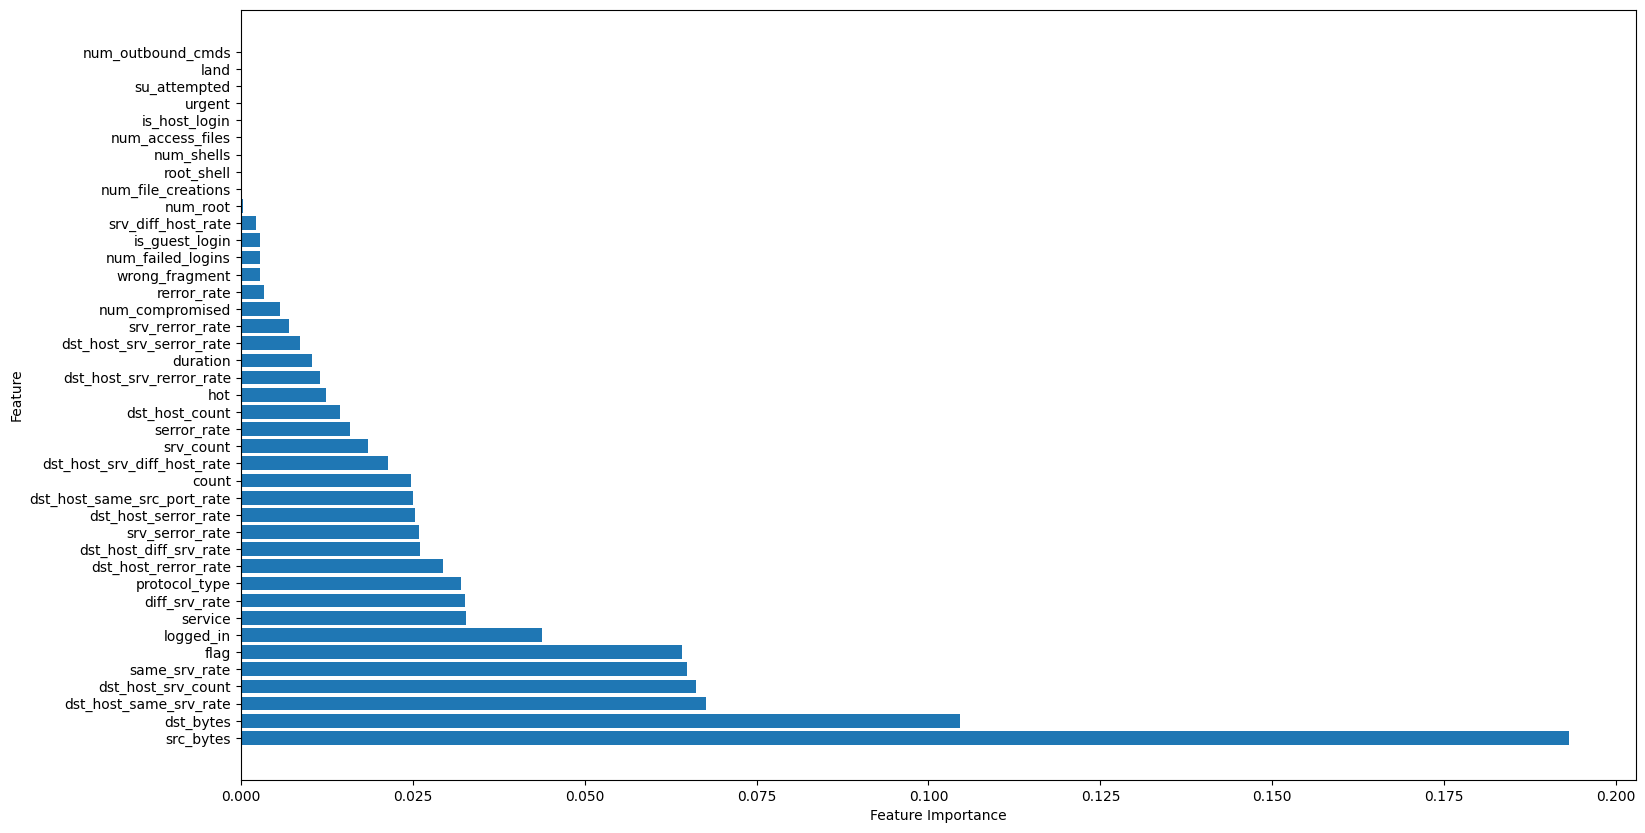

In [ ]:
plt.figure(figsize=(18, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

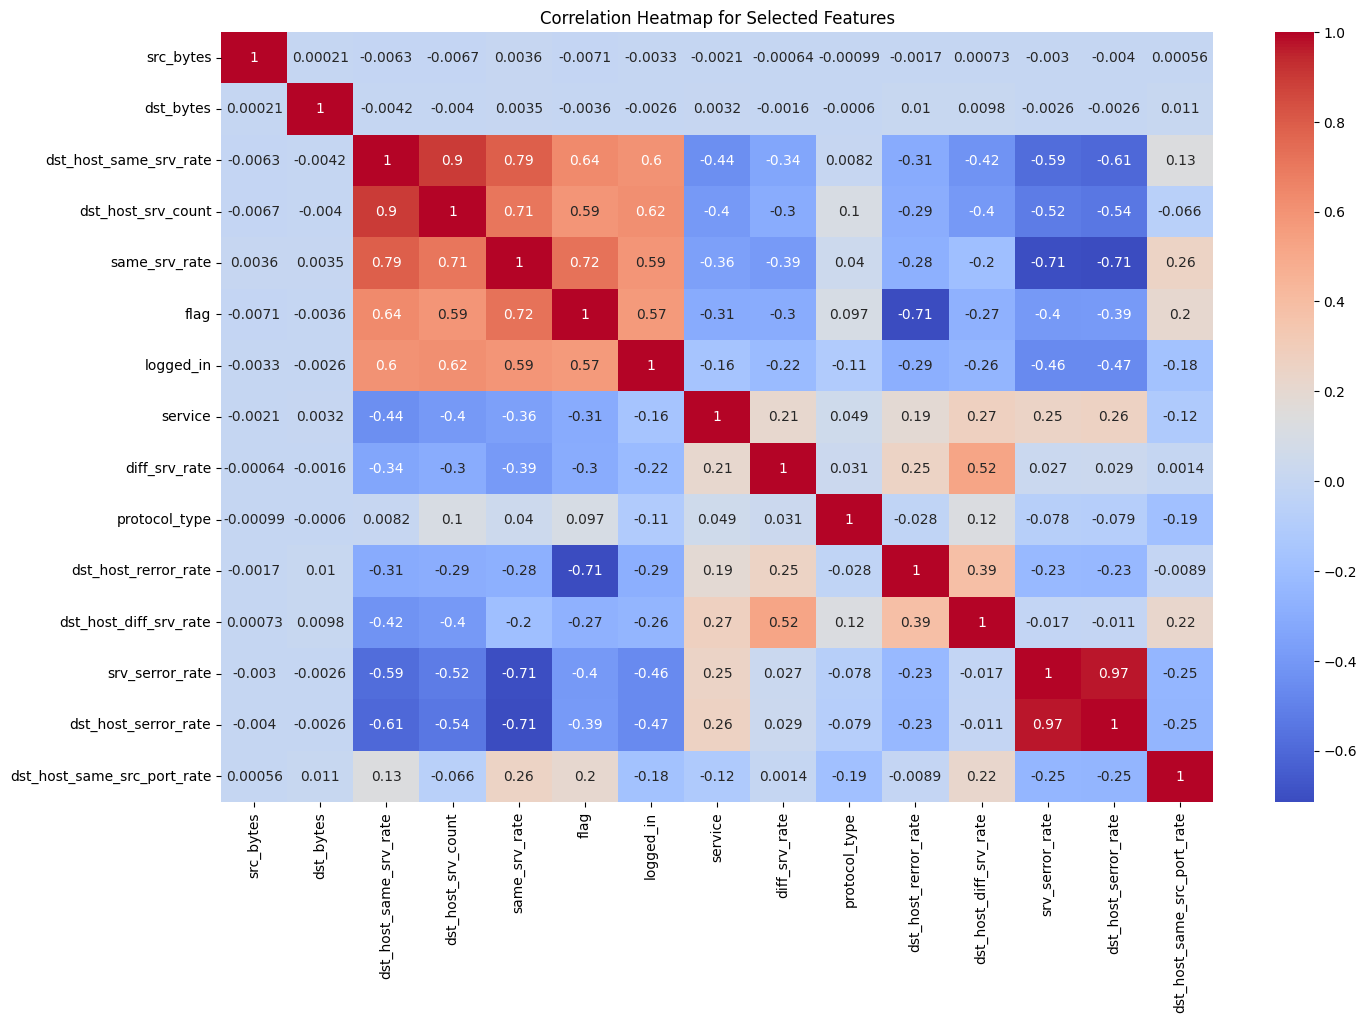

In [ ]:
selected_features_df = df_NSLKDD.loc[:, top_15_features]

correlation_matrix = selected_features_df.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Selected Features')
plt.show()

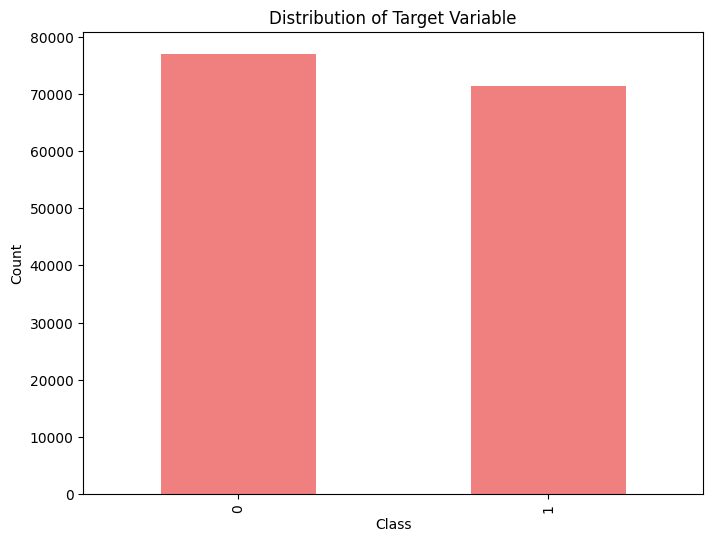

In [ ]:
plt.figure(figsize=(8, 6))
df_NSLKDD['attack_label'].value_counts().plot(kind='bar', color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

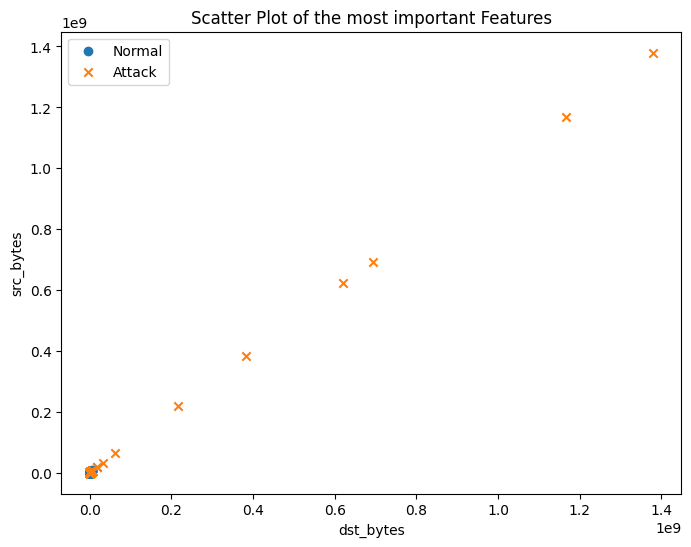

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_NSLKDD[df_NSLKDD['attack_label'] == 0]['dst_bytes'], df_NSLKDD[df_NSLKDD['attack_label'] == 0]['dst_bytes'], label='Normal', marker='o')
plt.scatter(df_NSLKDD[df_NSLKDD['attack_label'] == 1]['src_bytes'], df_NSLKDD[df_NSLKDD['attack_label'] == 1]['src_bytes'], label='Attack', marker='x')
plt.xlabel('dst_bytes')
plt.ylabel('src_bytes')
plt.legend()
plt.title('Scatter Plot of the most important Features')
plt.show()


## Decision tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_selected, Y)

DecisionTreeClassifier(random_state=42)

In [ ]:
Y_pred_DT = dt_model.predict(test_X_selected)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = accuracy_score(test_Y, Y_pred_DT)
precision = precision_score(test_Y, Y_pred_DT)
recall = recall_score(test_Y, Y_pred_DT)
f1 = f1_score(test_Y, Y_pred_DT)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.99
Precision: 0.99
Recall: 1.00
F1 Score: 0.99


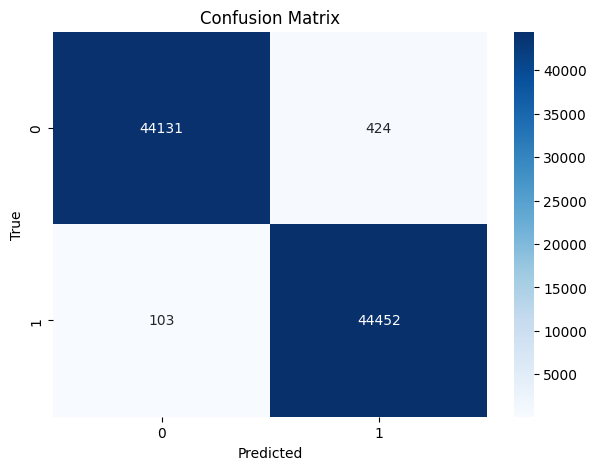

In [ ]:
cm = confusion_matrix(test_Y, Y_pred_DT)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Visualize the Decision Tree
#plt.figure(figsize=(20, 20))
#plot_tree(dt_model, feature_names=selected_features,
#          class_names=['Normal (0)', 'Attack (1)'], filled=True,fontsize=12,max_depth=5)
#plt.show()

NameError: ignored

<Figure size 2000x2000 with 0 Axes>

In [ ]:
import os
import joblib

model_dir = '/content/drive/My Drive/cmput_644_project/transfer_learning'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'tranfer_learning_Decision_tree_model.pkl')

joblib.dump(dt_model, model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/cmput_644_project/transfer_learning/tranfer_learning_Decision_tree_model.pkl


## lstm

In [ ]:
LSTM_X_train = X_selected.values.reshape(X_selected.shape[0], 1, X_selected.shape[1])
LSTM_X_test = test_X_selected.values.reshape(test_X_selected.shape[0], 1, test_X_selected.shape[1])

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(1, LSTM_X_train.shape[2]), activation='relu'))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_LSTM.fit(LSTM_X_train, Y, epochs=10, batch_size=64, validation_data=(LSTM_X_test, test_Y))

Epoch 1/10
2321/2321 [==============================] - 18s 6ms/step - loss: 226.2558 - accuracy: 0.9234 - val_loss: 0.7467 - val_accuracy: 0.9564
Epoch 2/10
2321/2321 [==============================] - 23s 10ms/step - loss: 454.8860 - accuracy: 0.9331 - val_loss: 4.5437 - val_accuracy: 0.9614
Epoch 3/10
2321/2321 [==============================] - 12s 5ms/step - loss: 91.1573 - accuracy: 0.9403 - val_loss: 4.8406 - val_accuracy: 0.9623
Epoch 4/10
2321/2321 [==============================] - 13s 6ms/step - loss: 166.1594 - accuracy: 0.9363 - val_loss: 33.8413 - val_accuracy: 0.9829
Epoch 5/10
2321/2321 [==============================] - 14s 6ms/step - loss: 426.3438 - accuracy: 0.9438 - val_loss: 37.2831 - val_accuracy: 0.9845
Epoch 6/10
2321/2321 [==============================] - 13s 5ms/step - loss: 823.7866 - accuracy: 0.9374 - val_loss: 78.2609 - val_accuracy: 0.9433
Epoch 7/10
2321/2321 [==============================] - 11s 5ms/step - loss: 229.6207 - accuracy: 0.9456 - val_loss

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_pred_LSTM = model_LSTM.predict(LSTM_X_test)
y_pred_LSTM = (y_pred_LSTM > 0.5).astype(int)

accuracy = accuracy_score(test_Y, y_pred_LSTM)
precision = precision_score(test_Y, y_pred_LSTM)
recall = recall_score(test_Y, y_pred_LSTM)
f1 = f1_score(test_Y, y_pred_LSTM)

cm = confusion_matrix(test_Y, y_pred_LSTM)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

2785/2785 [==============================] - 11s 4ms/step
Accuracy: 0.97
Precision: 0.95
Recall: 0.99
F1 Score: 0.97


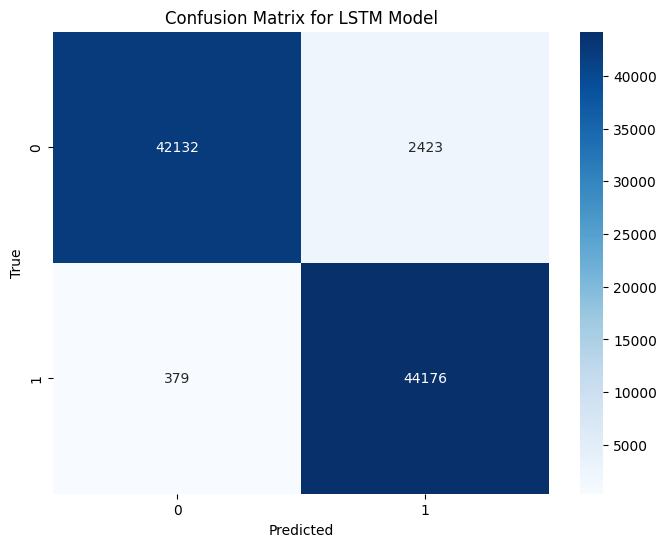

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [ ]:
import os
import joblib

model_dir = '/content/drive/My Drive/cmput_644_project/transfer_learning'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'transfer_learning_lstm_model.pkl')

joblib.dump(model_LSTM, model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/cmput_644_project/transfer_learning/transfer_learning_lstm_model.pkl
